In [642]:
import sys, json, requests
import yfinance as yf

import sklearn, numpy as np, scipy as scp, pandas as pd, matplotlib.pyplot as plt, matplotlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [643]:
margin = 0
period_of_time = '1y'
number_of_past_days = 4

# This is Where the Fun Begins

In [644]:
params = ['MFI', 'BBANDS', 'MACD', 'AROON', 'STOCHRSI']
comp = yf.Ticker('AAPL')
sym = comp.info['symbol']
company_data = comp.history(period=period_of_time)

In [645]:
print(company_data)

                                 Open        High         Low       Close  \
Date                                                                        
2022-06-07 00:00:00-04:00  143.493165  148.115558  143.244649  147.827286   
2022-06-08 00:00:00-04:00  147.698072  148.980408  146.584724  147.081757   
2022-06-09 00:00:00-04:00  146.206967  147.071798  141.683972  141.793320   
2022-06-10 00:00:00-04:00  139.447321  139.924467  136.246433  136.316025   
2022-06-13 00:00:00-04:00  132.081312  134.397484  130.659808  131.097198   
...                               ...         ...         ...         ...   
2023-05-31 00:00:00-04:00  177.330002  179.350006  176.759995  177.250000   
2023-06-01 00:00:00-04:00  177.699997  180.119995  176.929993  180.089996   
2023-06-02 00:00:00-04:00  181.029999  181.779999  179.259995  180.949997   
2023-06-05 00:00:00-04:00  182.630005  184.949997  178.039993  179.580002   
2023-06-06 00:00:00-04:00  179.970001  180.119995  177.429993  179.210007   

In [646]:
company_data = company_data.drop(['Dividends', 'Stock Splits'], axis=1)
print(company_data)

                                 Open        High         Low       Close  \
Date                                                                        
2022-06-07 00:00:00-04:00  143.493165  148.115558  143.244649  147.827286   
2022-06-08 00:00:00-04:00  147.698072  148.980408  146.584724  147.081757   
2022-06-09 00:00:00-04:00  146.206967  147.071798  141.683972  141.793320   
2022-06-10 00:00:00-04:00  139.447321  139.924467  136.246433  136.316025   
2022-06-13 00:00:00-04:00  132.081312  134.397484  130.659808  131.097198   
...                               ...         ...         ...         ...   
2023-05-31 00:00:00-04:00  177.330002  179.350006  176.759995  177.250000   
2023-06-01 00:00:00-04:00  177.699997  180.119995  176.929993  180.089996   
2023-06-02 00:00:00-04:00  181.029999  181.779999  179.259995  180.949997   
2023-06-05 00:00:00-04:00  182.630005  184.949997  178.039993  179.580002   
2023-06-06 00:00:00-04:00  179.970001  180.119995  177.429993  179.210007   

In [647]:
urls = {
    'SMA': ['https://www.alphavantage.co/query?function=SMA&symbol=', '&interval=daily&time_period=10&series_type=open&apikey=V9JMVK5EVUZZ2KPV'],
    'STOCHRSI': ['https://www.alphavantage.co/query?function=STOCHRSI&symbol=', '&interval=daily&time_period=10&series_type=open&fastkperiod=6&fastdmatype=1&apikey=V9JMVK5EVUZZ2KPV'],
    'MFI': ['https://www.alphavantage.co/query?function=MFI&symbol=', '&interval=daily&time_period=10&apikey=V9JMVK5EVUZZ2KPV'],
    'BBANDS': ['https://www.alphavantage.co/query?function=BBANDS&symbol=', '&interval=daily&time_period=20&series_type=open&nbdevup=2&nbdevdn=2&apikey=V9JMVK5EVUZZ2KPV'],
    'MACD' : ['https://www.alphavantage.co/query?function=MACD&symbol=', '&interval=daily&series_type=open&apikey=V9JMVK5EVUZZ2KPV'],
    'AROON' : ['https://www.alphavantage.co/query?function=AROON&symbol=', '&interval=daily&time_period=14&apikey=V9JMVK5EVUZZ2KPV'],
    'OBV' : ['https://www.alphavantage.co/query?function=OBV&symbol=', '&interval=weekly&apikey=V9JMVK5EVUZZ2KPV']
}

In [648]:
for p in params:
    url_arr = urls[p] # get url recipe from url dictionary
    url = url_arr[0] + sym + url_arr[1] # create API
    r = requests.get(url) # get response from query
    d = r.json()[f'Technical Analysis: {p}'] # filter for data
    df = pd.DataFrame.from_dict(d).T # convert to usable dataframe
    df = df[:len(company_data)] # only
    df = df.iloc[::-1] # flip dataframe upside-down
    for idx, col in enumerate(df):
    	company_data[col] = pd.to_numeric(df.iloc[:,idx].values, errors='coerce')

In [669]:
processed_data = company_data.copy()
fill_data = processed_data.describe()
for i in range(1,number_of_past_days+1): # add previous information from number_of_past_days to each row
    for idx,col in enumerate(company_data):
        processed_data[f'{col}_prev_{i}'] = company_data[col].shift(i, fill_value=fill_data[col].loc['mean'])

In [670]:
data = yf.Ticker(sym).history(period=period_of_time)[['Open', 'Close']] # pull Open and Close data to create target variables

In [671]:
processed_data['target_value'] = data.apply(lambda row: row.Close - row.Open, axis=1) # create difference column between open and close
processed_data['target_classifier'] = processed_data.apply(lambda row: 1 if(row.target_value >= margin) else 0, axis = 1) # create columns with 1 when gain is above the margine else 0

In [672]:
print(processed_data)

                                 Open        High         Low       Close  \
Date                                                                        
2022-06-07 00:00:00-04:00  143.493165  148.115558  143.244649  147.827286   
2022-06-08 00:00:00-04:00  147.698072  148.980408  146.584724  147.081757   
2022-06-09 00:00:00-04:00  146.206967  147.071798  141.683972  141.793320   
2022-06-10 00:00:00-04:00  139.447321  139.924467  136.246433  136.316025   
2022-06-13 00:00:00-04:00  132.081312  134.397484  130.659808  131.097198   
...                               ...         ...         ...         ...   
2023-05-31 00:00:00-04:00  177.330002  179.350006  176.759995  177.250000   
2023-06-01 00:00:00-04:00  177.699997  180.119995  176.929993  180.089996   
2023-06-02 00:00:00-04:00  181.029999  181.779999  179.259995  180.949997   
2023-06-05 00:00:00-04:00  182.630005  184.949997  178.039993  179.580002   
2023-06-06 00:00:00-04:00  179.970001  180.119995  177.429993  179.210007   

In [673]:
#data5 = data5.shift(-(number_of_past_days))
#data5.drop(data5.tail(number_of_past_days).index, inplace=True)

In [674]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-06-07 00:00:00-04:00 to 2023-06-06 00:00:00-04:00
Data columns (total 87 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Open                     251 non-null    float64
 1   High                     251 non-null    float64
 2   Low                      251 non-null    float64
 3   Close                    251 non-null    float64
 4   Volume                   251 non-null    int64  
 5   price_change             251 non-null    float64
 6   MFI                      251 non-null    float64
 7   Real Upper Band          251 non-null    float64
 8   Real Middle Band         251 non-null    float64
 9   Real Lower Band          251 non-null    float64
 10  MACD                     251 non-null    float64
 11  MACD_Signal              251 non-null    float64
 12  MACD_Hist                251 non-null    float64
 13  Aroon Down               251 no

In [675]:
processed_data = processed_data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)

array([[<AxesSubplot:title={'center':'MFI'}>,
        <AxesSubplot:title={'center':'Real Upper Band'}>,
        <AxesSubplot:title={'center':'Real Middle Band'}>,
        <AxesSubplot:title={'center':'Real Lower Band'}>,
        <AxesSubplot:title={'center':'MACD'}>,
        <AxesSubplot:title={'center':'MACD_Signal'}>,
        <AxesSubplot:title={'center':'MACD_Hist'}>,
        <AxesSubplot:title={'center':'Aroon Down'}>,
        <AxesSubplot:title={'center':'Aroon Up'}>],
       [<AxesSubplot:title={'center':'FastK'}>,
        <AxesSubplot:title={'center':'FastD'}>,
        <AxesSubplot:title={'center':'Open_prev_1'}>,
        <AxesSubplot:title={'center':'High_prev_1'}>,
        <AxesSubplot:title={'center':'Low_prev_1'}>,
        <AxesSubplot:title={'center':'Close_prev_1'}>,
        <AxesSubplot:title={'center':'Volume_prev_1'}>,
        <AxesSubplot:title={'center':'price_change_prev_1'}>,
        <AxesSubplot:title={'center':'MFI_prev_1'}>],
       [<AxesSubplot:title={'center':

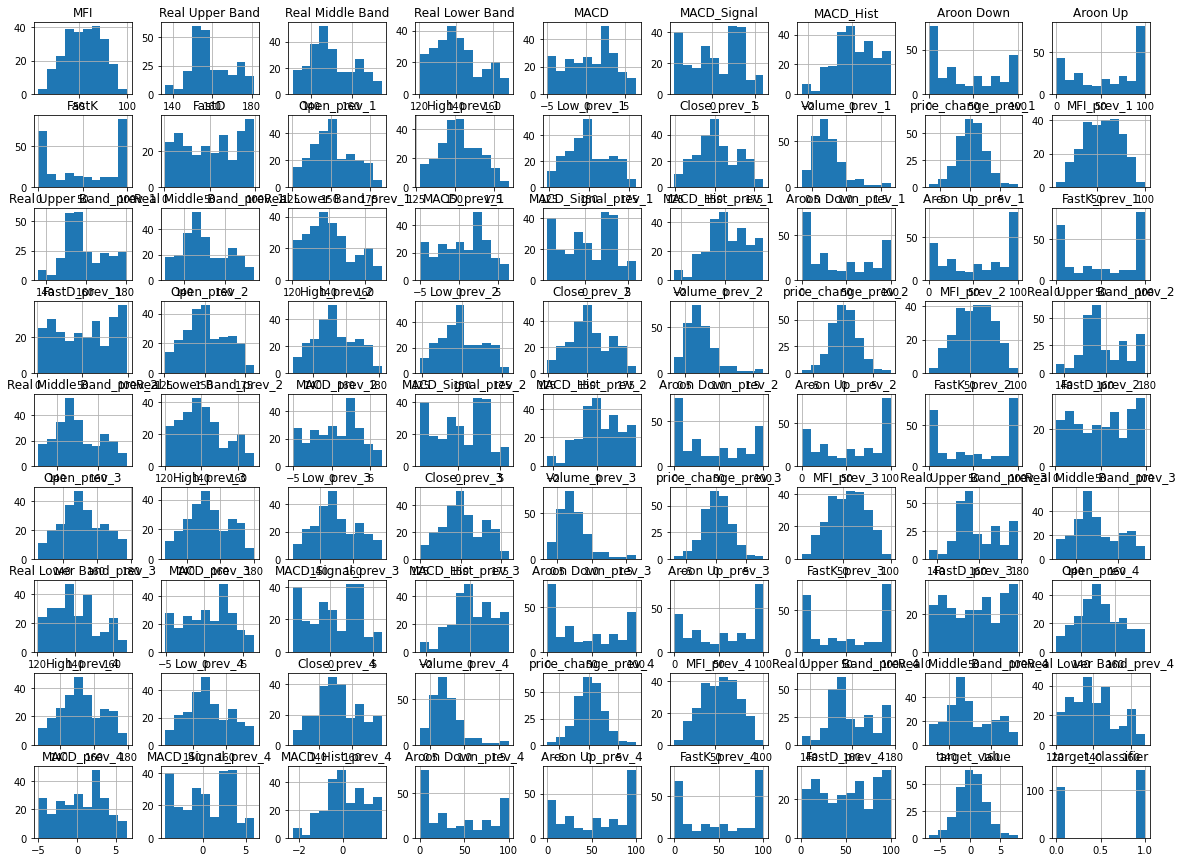

In [676]:
processed_data.hist(figsize=(20,15))

In [677]:
correlations = processed_data.corr()
correlations['target_classifier'].sort_values(ascending=False)

target_classifier    1.000000
target_value         0.774228
Aroon Up             0.195522
MFI                  0.124519
MACD_Hist_prev_4     0.120651
                       ...   
Aroon Down_prev_1   -0.111316
Aroon Down          -0.123833
Volume_prev_4       -0.133105
FastK_prev_2        -0.134456
Volume_prev_3       -0.154580
Name: target_classifier, Length: 81, dtype: float64

array([[<AxesSubplot:title={'center':'MFI'}>,
        <AxesSubplot:title={'center':'Real Upper Band'}>,
        <AxesSubplot:title={'center':'Real Middle Band'}>,
        <AxesSubplot:title={'center':'Real Lower Band'}>,
        <AxesSubplot:title={'center':'MACD'}>,
        <AxesSubplot:title={'center':'MACD_Signal'}>,
        <AxesSubplot:title={'center':'MACD_Hist'}>,
        <AxesSubplot:title={'center':'Aroon Down'}>,
        <AxesSubplot:title={'center':'Aroon Up'}>],
       [<AxesSubplot:title={'center':'FastK'}>,
        <AxesSubplot:title={'center':'FastD'}>,
        <AxesSubplot:title={'center':'Open_prev_1'}>,
        <AxesSubplot:title={'center':'High_prev_1'}>,
        <AxesSubplot:title={'center':'Low_prev_1'}>,
        <AxesSubplot:title={'center':'Close_prev_1'}>,
        <AxesSubplot:title={'center':'Volume_prev_1'}>,
        <AxesSubplot:title={'center':'price_change_prev_1'}>,
        <AxesSubplot:title={'center':'MFI_prev_1'}>],
       [<AxesSubplot:title={'center':

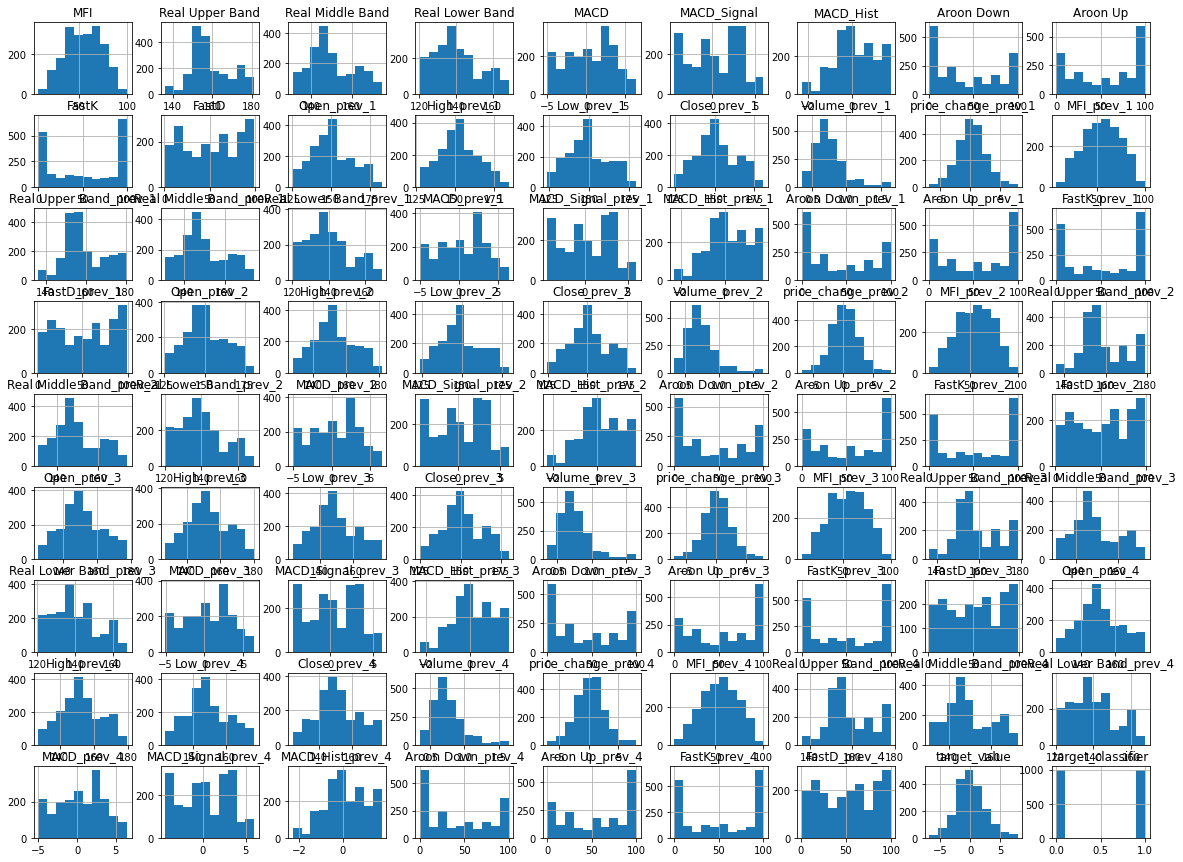

In [678]:
# upsample and desample to make classes balanced
# assumes target is at the end of the row
data_1 = processed_data[processed_data.iloc[:,-1] == 1]
data_0 = processed_data[processed_data.iloc[:,-1] == 0]

data_1_normalized = resample(data_1, replace=True, n_samples=1000)
data_0_normalized = resample(data_0, replace=True, n_samples=1000)

processed_data = pd.concat([data_1_normalized, data_0_normalized])
processed_data.hist(figsize=(20,15))

In [679]:
correlations = processed_data.corr()
print(correlations['target_classifier'].sort_values(ascending=False)[0:60])
print(correlations['target_classifier'].sort_values(ascending=False)[60:])

target_classifier          1.000000
target_value               0.775449
Aroon Up                   0.177939
MACD_Hist_prev_4           0.104271
MFI                        0.101124
Aroon Up_prev_1            0.092838
MFI_prev_4                 0.078794
Aroon Up_prev_3            0.073772
MACD_Hist_prev_3           0.065433
MACD_Signal_prev_1         0.055824
MACD_prev_1                0.055741
Aroon Up_prev_4            0.055224
MACD_prev_2                0.052365
MACD_prev_3                0.051944
FastD_prev_4               0.051867
MACD_prev_4                0.051814
MACD                       0.051029
MACD_Signal                0.049872
Aroon Up_prev_2            0.047441
MACD_Signal_prev_2         0.045120
MACD_Signal_prev_3         0.032517
FastK                      0.030116
MACD_Hist_prev_2           0.028656
MACD_Signal_prev_4         0.019299
MFI_prev_3                 0.017215
MFI_prev_2                 0.012147
MACD_Hist                  0.011507
FastK_prev_4               0

In [680]:
y = processed_data['target_classifier']
x = processed_data.drop(['target_classifier','target_value'],axis=1)
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.25, random_state=0)

In [681]:
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

In [682]:
#Transform raw data 
train = pipeline.fit_transform(train_raw)
test = pipeline.transform(test_raw)
x_norm = pipeline.fit_transform(x)

In [683]:
lr = LogisticRegression(penalty='l1',max_iter=1000, solver="liblinear")
lr.fit(train,target)
predicted = lr.predict(test)

In [684]:
accuracy = sklearn.metrics.accuracy_score(target_test,predicted)
tomorrow_pred = lr.predict(x_norm[len(x_norm)-1:])
print(tomorrow_pred, accuracy)

[0] 0.794


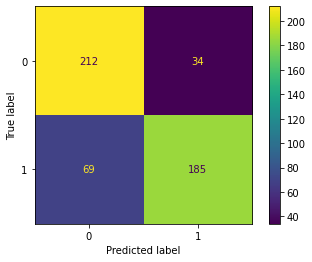

In [685]:
cm = confusion_matrix(target_test, predicted, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()
plt.show()

In [686]:
print(classification_report(target_test, predicted, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       246
           1       0.84      0.73      0.78       254

    accuracy                           0.79       500
   macro avg       0.80      0.80      0.79       500
weighted avg       0.80      0.79      0.79       500

